In [6]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 125044 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfon

In [7]:
# Install gymnasium if you didn't
!pip install "gymnasium[toy_text,classic_control]"

In [26]:
import torch
from torch import nn
import numpy as np
import gym
import random
import matplotlib.pyplot as plt

class CEMContinuous(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        #self.network2 = nn.Sequential(
        #    nn.Linear(self.state_dim, 64),
        #    nn.LeakyReLU(),
        #    nn.Linear(64, self.action_dim),
        #    nn.Tanh()
        #)

        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh())
        self.loss = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state, noise_std=0.1):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.forward(state).squeeze().detach().numpy()
       # print(action)
        noise =  noise_std * np.random.randn(self.action_dim)
        action += noise
       # print(noise)
        action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
        return action


    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for elite_trajectory in elite_trajectories:
            for state, action in zip(elite_trajectory['states'], elite_trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)

        if not elite_states:
            print("No elite states collected. Check the trajectories.")
            return

        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.FloatTensor(np.array(elite_actions))
        for epoch in range(10):
            loss = self.loss(self.forward(elite_states).squeeze(), elite_actions)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

In [27]:
def get_trajectory(env, agent, trajectory_len, noise_std=0.1, visualize=False):
    trajectory = {'states': [], 'actions': [], 'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)

    for _ in range(trajectory_len):
        action = agent.get_action(state, noise_std)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        if done:
            break

        if visualize:
            env.render()

        trajectory['states'].append(state)

    return trajectory

In [28]:
elite_container = []
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)

    for trajectory in trajectories:
        if trajectory['total_reward'] > 200:
            elite_container.append(trajectory)

    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [29]:
!pip install swig

In [13]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379495 sha256=1e096d68bd7e89dc6401c5f84615b14630225c59f92fb0cfd2688882f228c238
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [33]:
env = gym.make('LunarLander-v2', continuous=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [34]:
import numpy as np
import matplotlib.pyplot as plt
def run_cem_agent(agent, episode_n, trajectory_n, trajectory_len, start_sigma, end_sigma, start_q, end_q, coef):
    scores = []
    for episode in range(episode_n):
        trajectories = []
        for _ in range(trajectory_n):
            cur = episode
            if cur > coef:
                cur = coef
            noise_std = start_sigma - (start_sigma - end_sigma) * cur / coef
            trajectory = get_trajectory(env, agent, trajectory_len, noise_std)
            trajectories.append(trajectory)

        q_param = start_q + (end_q - start_q) * episode / episode_n
        elite_trajectories = get_elite_trajectories(trajectories, q_param)

        agent.update_policy(elite_trajectories)

        episode_rewards = [trajectory['total_reward'] for trajectory in trajectories]
        mean_reward = np.mean(episode_rewards)
        scores.append(mean_reward)

    return scores

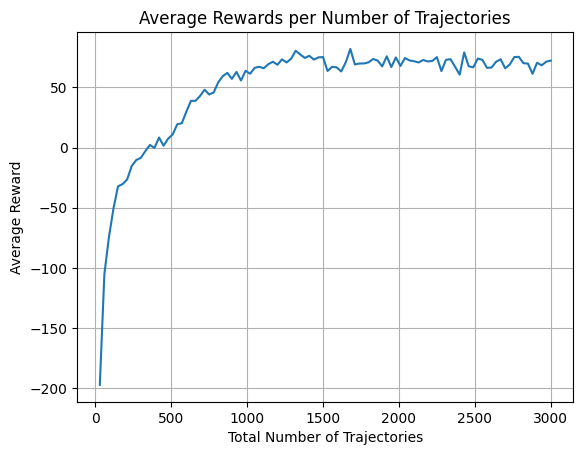

In [35]:
episode_n = 100
trajectory_n = 30
trajectory_len = 100
start_sigma = 0.9
end_sigma = 0.05
start_q = 0.8
end_q = 0.95
coef = episode_n / 2

num_agents = 2
all_scores_CEM = []
for _ in range(num_agents):
    agent = CEMContinuous(state_dim, action_dim)
    agent_scores = run_cem_agent(agent, episode_n, trajectory_n, trajectory_len, start_sigma, end_sigma, start_q, end_q, coef)
    all_scores_CEM.append(agent_scores)

avg_scores = np.mean(np.array(all_scores_CEM), axis=0)

total_trajectories = np.arange(trajectory_n, episode_n * trajectory_n + 1, trajectory_n)

plt.plot(total_trajectories, avg_scores)
plt.title('Average Rewards per Number of Trajectories')
plt.xlabel('Total Number of Trajectories')
plt.ylabel('Average Reward')
plt.grid()
plt.show()